# STEP ONE:
## Single line hypothesis test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial, special, optimize as op
from itertools import combinations
from tqdm import tqdm
from time import time
from IPython.display import Latex
import pystan
import spectroscopy_net as sn

import random 
random.seed(1) 

# Parameters
We set up a dictionary of the parameters we wish to use to create our toy data for the reference and the observed measurements. 

- ```theta_true``` = the vaules for our parameters in our linear model, In this case we can access the gradient coefficient with ```theta_true[0]``` and the translation constant with ```theta_true[1]``` .
- ```deg``` = The degrees or order of the equation we are using, used in ```np.polyfit()``` to return linear equation. for linear equation we have 1 degree, polynomial has deg>1.
- ```N_ref``` = the number of emission lines we want the reference data to contain. 
- ```N_obs``` = the number of emission lines we want the observation data to contain. 
- ```N_pix``` = number of pixels in the ccd.
- ```f``` = fraction of emission lines in observation data that are not in the reference data.
- ```p``` = number of lines used to create hash (excluding the edges). So  ``` p = 1 ``` means ```[-1, 0.76, 1]``` 
- ```wl_lower, wl_upper``` = lower and upper limit of reference measurements 
- ```intrinsic_px_obs_err``` = error in the observation 
- ```intrinsic_wl_ref_err``` = error in the reference list 
- ```min_bayes_factor``` = minimum bayes factor before accepting a solution



In [2]:
theta_true = np.array([0.4523, 328])
N_ref = 100
N_obs = 10
N_pix = 2048
f = 0.2
p = 1 
k = 1 

min_bayes_factor = 10**9 
wl_lower, wl_upper = (300, 1200)
deg = len(theta_true) - 1


data_kwds = dict(N_ref=N_ref, N_obs=N_obs, N_pix=N_pix,
                 wl_lower=wl_lower, wl_upper=wl_upper,
                 f=f, intrinsic_px_obs_err=1e-2, intrinsic_wl_ref_err=1e-3)

# Generating The Data
Explaination of the ```generate_data()``` function.

For this experiemnt to work we want to have two list of data, a reference list and an observation list. These two data sets will be related by some linear or polynomial equation. 

\begin{align}
a_{0}x^{n} + a_{1}x^{n-1} + \cdot \cdot \cdot + a_{n} = y
\end{align}

Where x is the pixel value and y is the measurement in angstroms.

1. Using ```np.random.uniform()``` we create an array of observation data in the range (0, N_pix) with the number of lines defined by N_obs

2. We create the reference data by taking these measurements and applying our equation to them with ```np.polyval(theta, px_obs)```
3. We randomly remove a fraction of the observed emission lines, Then combine the observed data (some missing) to many randomly generated lines.

```
K = int(N_obs * (1 - f))
idx = np.random.choice(N_obs, K, replace=False)
wl_ref = np.hstack([wl_obs[idx],np.random.uniform(wl_lower, wl_upper, N_ref - K)]) 
```

4. Now we create an array of length N_ref to represent brightness of emission lines (amp_ref) using ```np.random.multivariate_normal()```

5. Now add a duplicate array with different scaling and a slight varience in relative brightness for the obs_amp
6. Select the first K from the obs_amp list which correspond to the 8 measurements in our obs data that are also in the ref data. For lines that are in obs but not ref randomly select their amplitudes.
8. Create two arrays called obs (3 x N_obs) and ref (3 x N_ref) that contain pixel/wavelength, brightness and noise for each measurement


In [3]:
def generate_data(theta, N_ref, N_obs, N_pix, f=0.1, wl_lower=300, wl_upper=1200,
                  intrinsic_px_obs_err=1e-3, intrinsic_wl_ref_err=1e-2,
                  amp_obs_scale=10000, amp_ref_scale=65535):

    px_obs = np.random.uniform(0, N_pix, N_obs)
    wl_obs = np.polyval(theta, px_obs)

    K = int(N_obs * (1 - f))
    idx = np.random.choice(N_obs, K, replace=False)

    wl_ref = np.hstack([
        wl_obs[idx],
        np.random.uniform(wl_lower, wl_upper, N_ref - K)
    ])

    unscaled_amplitudes = np.random.multivariate_normal([0, 0], 
                                                        [[1, 0.9], [0.9, 1]], 
                                                        size=N_ref)

    amp_obs_scale, amp_ref_scale = (10000, 65535)
    amplitudes = (unscaled_amplitudes - np.min(unscaled_amplitudes, axis=0)) \
               / np.ptp(unscaled_amplitudes, axis=0) \
               * np.array([amp_obs_scale, amp_ref_scale])

    amp_obs_known, amp_ref = (amplitudes.T[0][:K], amplitudes.T[1])


    amp_obs = np.random.uniform(0, amp_obs_scale, size=N_obs)
    amp_obs[idx] = amp_obs_known

    px_obs_err = np.random.normal(intrinsic_px_obs_err, intrinsic_px_obs_err/10, size=N_obs)
    wl_ref_err = np.random.normal(intrinsic_wl_ref_err, intrinsic_wl_ref_err/10, size=N_ref)

    px_obs += np.random.normal(0, intrinsic_px_obs_err, size=N_obs)
    wl_ref += np.random.normal(0, intrinsic_wl_ref_err, size=N_ref)

    obs = (px_obs, amp_obs, px_obs_err)
    ref = (wl_ref, amp_ref, wl_ref_err)
    return obs, ref, wl_obs

# Combinations
Nice example of how doing maths in log rapidly speeds up computation time

By taking the log of equations we an rapidly speed up compution time. For example, We will be dealing with combinations and perumtations in this project. As an example, The equation for combinations is seen below with 
- c = number of combinations
- n = number of objects in set 
- q = number of objects chosen from n

\begin{align}
c = \frac{n!}{q!(n-q)!} \\
\end{align}

\begin{align}
\log{c} = \log{n!} - \log{q!} - \log{(n-q)!} \\
\end{align}



In the code we use special functions for computing the log factorials whihc require the +1 inside the log.

In [4]:
def number_of_combinations(n, q):

    C = np.exp(special.loggamma(n + 1) - special.loggamma(q + 1) - special.loggamma(n + 1 - q))
    return int(np.round(C))

# KD-Trees
An index into a set of k-dimensional points which can be used to rapidly look up the nearest neighbors of any point. 

(Maneewongvatana and Mount 1999)


1. Create the shapes for memmaps of both indices and ratios for our reference list for quick retrival and file handling.
2. Here we use a loop to populate the memmap for both ratios and indices.
3. Because we are only queering for the ratio we create the KD-tree on this memmap only.
4. This KD-tree contains the ratios of all the combinations in the reference list.

We create the ratios here using the transofrmation:


\begin{align}
Mid = \frac{V - (V_{max} + V_{min})}{2}
\end{align}


\begin{align}
\vec{V}_{transformed} = \frac{\vec{V} - Mid}{max(\vec{V} - Mid)}
\end{align}


In [5]:
def grow_tree(wl_ref, p=1):

    if p < 1:
        raise ValueError("p > 1")

    q = p + 2
    n = len(wl_ref)
    t = number_of_combinations(n, p + 2)

    indices = np.memmap("indices_1.memmap", mode="w+", shape=(t, q), dtype=int)
    ratios = np.memmap("ratios_1.memmap", mode="w+", shape=(t, p), dtype=float)

    for i, idx in tqdm(enumerate(combinations(range(n), q)), total=t, disable=True):
        # note that itertools.combinations gives positive ordered values
        v = np.sort(wl_ref[list(idx)])
        ratios[i] = (v[1:-1] - v[0])/(v[-1] - v[0])
        indices[i] = idx

    tree = spatial.KDTree(ratios)

    return indices, ratios, tree

# Background Model

We have to compare our hypothesised solution and how likely it is to a solution that is definitly wrong. We call the incorrect solution the background model. 
To generate a figure for this model, we calcuate the probability of the case where an emission line in our camera is equally likely to be at any position in the range of the reference data. 
We then sum the probabilities for all our measured lines to obtain the total probability of the background (wrong) model. 

\begin{align}
Pr_{BKG}= \sum_{n = 0}^{N_{obs}} \frac{1^{n}}{ref_{max} - ref_{min}}
\end{align}

We of course do this in log to save computational power.

\begin{align}
ln(Pr_{BKG})= \sum_{n = 0}^{N_{obs}} -(1^{n})\log{(ref_{max} - ref_{min})}
\end{align}



# Foreground Model

The foreground model is perhaphs the most important part of this code, This is the probability of what we believe to be the correct solution. 
We consider how likely our hypothesised solution is by evaluating the normal distribution around each of the reference wavelengths and seeing how well our estimated wavelength fits into this distribution. 

The normal distribution has the following form:

- $\mu$ = Mean
- $\sigma$ = Standard deviation 
- $\sigma^{2}$ = Variance

\begin{align}
\mathcal{L} = \frac{1}{\sqrt{2 \pi \sigma^{2}}} exp\Big[-\frac{(x-\mu)^{2}}{2 \sigma^{2}}\Big]
\end{align}

Of course we transform this into a log equation to save computational time.

\begin{align}
\log{(\mathcal{L})} = -\log{\Big(\sqrt{2 \pi \sigma^{2}}\Big)} - \frac{(x- \mu)^{2}}{2 \sigma^{2}}
\end{align}

As the first term is just a constant we can simply write 

\begin{align}
\log{(\mathcal{L})} = K - \frac{1}{2} \chi^{2}
\end{align}

Where $\chi^{2} = (Obs-Ref)^{2}$

Hence to retrive the maximum likelihood we want to minimize $\chi^{2}$ 

We calculate this by considering...
- ```theta``` = best fit parameters for relating pixel value to wavelength. 
- ```px_obs``` = The measurements.
- ```wl_ref``` = Reference list.
- ```px_obs_error``` = Error in the measurements.
- ```wl_ref_error``` = Error in the reference measurements. 


1. We first use our parameters from our hypothesised solution to map our observations to Agnstroms. 
2. We now take each measurement in Agnstroms and calculate the closest match in the reference list. Doing this for each one we find a closest match to all our observation measurements.
3. We then calculate the chi squared value for each of our observations given the uncertainties and see how well each observation is explained by these parameters given the noise. does it fit or not?





In [6]:
def ll_foreground(theta, px_obs, wl_ref, px_obs_err=1e-3, wl_ref_err=1e-3):
    
    wl_obs = np.polyval(theta, px_obs).reshape(-1, 1)
    D = spatial.distance_matrix(wl_obs, wl_ref.reshape(-1, 1))
    idx = np.argmin(D, axis=1)
    best_match = wl_ref[idx]
    chisq = np.min(D, axis=1)**2

    # TODO: do the ivar properly 
    ivar = wl_ref_err**-2
    return -0.5 * chisq * ivar, best_match 

def ll_background(px_obs):
    return -np.ones(len(px_obs)) * np.log(wl_upper - wl_lower)

# Mixture Model 

Since some of the data in our observation list wont be in the reference list, when we calculate the probability and bayes factor of our foreground vs background model we need to use a mixture model that accounts for some of the data being outliers. 

Normaly the likelihood without a mixture model would be calculated by the following...


\begin{align}
\mathcal{L} = \prod_{i=1}^{N} p( y_{i} | x_{i}, \sigma_{yi}, m, b)
\end{align}

With a Bayesian generalization of:

\begin{align}
p( m, b | \{ y_{i} \}_{i=1}^{N}, I) = \frac{p( \{ y_{i} \}_{i=1}^{N} | m, b, I)p(m, b|I)}{p(\{y_{i} \}_{i=1}^{N}|I)}
\end{align}


Where $m, b$ are model parameters, $\{ y_{i} \}_{i=1}^{N}$ is all the data $y_{i}$ and $I$ is prior knowledge of the $x_{i}$ and $ \sigma_{yi}$

But this assumes that all the data is "good", which in our case is not. And hence, to account for this unknown fraction of outliers, when we calculate our likelihood and bayes factor we need to add some more parameters. We add a parameter $P_{b}$, which a binary flag associated to each point. We also have to account for the mean and varience of our "bad" points in $y$ so we also add parameters $Y_{b}$ and $V_{b}$.

We can pick a simple model for $p(P_{b})$, Where $Q \in [0,1]$ is a constant that sets the prior probability a point is either good or bad. (the fraction of outliers in our data)

\begin{align}
p(P_{b}) = 
\begin{cases}
Q \quad{} \quad{} \text{if} \quad{} P_{b} = 0\\ 1-Q \quad{} \text{if} \quad{} P_{b} = 1
\end{cases}
\end{align}

With this the likelihood now becomes:

\begin{align}
\mathcal{L} = \prod_{i=1}^{N} [p_{fg}(\{ y_{i} \}_{i=1}^{N}|m, b, I)]^{q_{i}} [p_{bg}(\{ y_{i} \}_{i=1}^{N}|Y_{b}, V_{b}, I)]^{1-q_{1}}
\end{align}


\begin{align}
\mathcal{L} = \prod_{i=1}^{N} \Big[\frac{1}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp(- \frac{(y_{i} -mx_{i} - b)^{2}}{2 \sigma_{yi}^{2}})\Big]^{q_{i}} \Big[\frac{1}{\sqrt{2 \pi (V_{b} + \sigma_{yi}^{2})}} \exp(-\frac{(y_{i} - Y_{b})^{2}}{2(V_{b} + \sigma_{yi}^{2})})\Big]^{1-q_{i}}
\end{align}


If we define $\theta = (m, b, \{q_{i} \}_{i=1}^{N}, P_{b}, Y_{b}, V_{b})$  then the Bayesian generalization becomes:

\begin{align}
p(\theta, I) = \frac{p( \{ y_{i} \}_{i=1}^{N} | \theta, I)p(\theta |I)}{p(\{y_{i} \}_{i=1}^{N}|I)}
\end{align}


\begin{align}
\mathcal{L} = \prod_{i=1}^{N} \Big[\frac{1}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp(- \frac{(y_{i} -mx_{i} - b)^{2}}{2 \sigma_{yi}^{2}})\Big]^{q_{i}} \Big[\frac{1}{\sqrt{2 \pi (V_{b} + \sigma_{yi}^{2})}} \exp(-\frac{(y_{i} - Y_{b})^{2}}{2(V_{b} + \sigma_{yi}^{2})})\Big]^{1-q_{i}}
\end{align}


# Likelihood Function

This caclulates the likelihood of our model given the equation below:

\begin{align}
\mathcal{L} = \prod_{i=1}^{N} \Big[\frac{1}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp(- \frac{(y_{i} -mx_{i} - b)^{2}}{2 \sigma_{yi}^{2}})\Big]^{q_{i}} \Big[\frac{1}{\sqrt{2 \pi (V_{b} + \sigma_{yi}^{2})}} \exp(-\frac{(y_{i} - Y_{b})^{2}}{2(V_{b} + \sigma_{yi}^{2})})\Big]^{1-q_{i}}
\end{align}



# Prior Function


This function takes a single or array of $Q$ values and asigns its binary value acording to the following model:

\begin{align}
p(P_{b}) = 
\begin{cases}
Q \quad{} \quad{} \text{if} \quad{} P_{b} = 0\\ 1-Q \quad{} \text{if} \quad{} P_{b} = 1
\end{cases}
\end{align}

If we know which points are bad we can assign that at this stage but because we dont we just treate all points equally


# Probability Function

Combines the prior with the likelihood to determine the probability of a range of prior values

In [7]:
def ln_likelihood(w, theta, px_obs, wl_ref):
    w = np.atleast_2d(w).T
    bg = np.log(1-w) + np.atleast_2d(ll_background(px_obs))
    
    fg_ln, best_match = ll_foreground(theta, px_obs, wl_ref)
    
    fg = np.log(w) + np.atleast_2d(fg_ln)
    return np.sum(special.logsumexp([bg, fg], axis=0), axis=1), best_match

def ln_prior(w, theta):
    lp = np.zeros(np.atleast_1d(w).size)
    lp[(w > 1) | (w < 0)] = -np.inf
    return lp

def ln_probability(w, theta, px_obs, wl_ref):
    like_ln, best_match = ln_likelihood(w, theta, px_obs, wl_ref)
    ln_prob = ln_prior(w, theta) + like_ln
    return ln_prob, best_match 

# Run Example

Now we will test how well this works with a simple base case.

1. Generate data
2. Build background model and prob
3. Build KD-Tree

In [8]:
obs, ref, wl_obs = sn.generate_data(theta_true, **data_kwds)
px_obs, amp_obs, px_obs_err = obs
wl_ref, amp_ref, wl_ref_err = ref
C = number_of_combinations(len(px_obs), p + 2)
ln_bg_prob = np.sum(ll_background(px_obs))
indices, ratios, tree = grow_tree(wl_ref, p=p)

ValueError: not enough values to unpack (expected 3, got 2)

# Solve Problem
Now we will use the data generated above and run the observations through our hypothesis test to try and the correct reference wavelength that matchs to what was measured in our CCD


1. Set variable ```best_bayes_factor``` and ```best_theta``` to None to start with
2. Create combinations from observation list and sort by brightest lines first
3. Select one and calculate the ratio
4. With this ratio query the KD-Tree for a match
5. Once a match is found calculate the ```theta``` values from these three lines
6. Apply theta value to rest of obs lines and record hypothesised all line matches as ```wl_ref_match```
7. Create a grid of 100 values representing fraction of outliers to 1%
8. Calculate the proability given our observations, the reference list and our theta values for each fraction of outliers. 
9. Save the fraction of outliers that provide the highest probability from our grid
10. With this best outlier fraction calculate the bayes factor
11. If the bayes factor is above our threshold, end and provide solution

  0%|          | 0/120 [00:00<?, ?it/s]

Solution found
Bayes Factor: [7.85363452e+11]
Guessed Theta: [  0.45229902 328.00242292]
True Theta: [  0.4523 328.    ]
Theta diff: 5.870547761716746e-06
Fraction of outliers: 0.5858585858585859


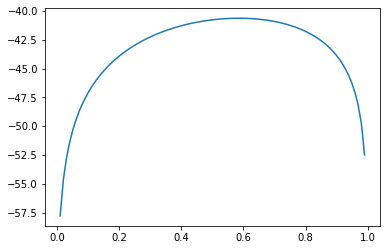

In [9]:
best_bayes_factor, best_theta = (None, None)

for i, obs_idx in tqdm(enumerate(combinations(np.argsort(amp_obs), p + 2)), total=C):
    px_obs_ = np.sort(px_obs[list(obs_idx)])
    ratios = (px_obs_[1:-1] - px_obs_[0])/(px_obs_[-1] - px_obs_[0])
    print(ratios)
    ds, idxs = map(np.atleast_1d, tree.query(ratios, k=k))

    for d, idx in zip(ds, idxs):
        wl_ref_ = np.sort(wl_ref[indices[idx]])
        theta = np.polyfit(px_obs_, wl_ref_, deg)
        ws = np.linspace(0, 1, 100)[1:-1]
        
        ln_prob_best, best_match = ln_probability(ws, theta, px_obs, wl_ref)
        
        w = ws[np.argmax(ln_prob_best)]
        
        ln_prob, best_match = ln_probability(w, theta, px_obs, wl_ref)
        
        bayes_factor = np.exp(ln_prob - ln_bg_prob)

        if best_bayes_factor is None or bayes_factor > best_bayes_factor:
            best_bayes_factor, best_theta = (bayes_factor, theta)

        if bayes_factor > min_bayes_factor:
            break

    if best_bayes_factor > min_bayes_factor:
        print("Solution found")
        print("Bayes Factor:", best_bayes_factor)
        print("Guessed Theta:", theta)
        print("True Theta:", theta_true)
        before = np.sum((theta_true - theta)**2)
        print("Theta diff:", before)
        print("Fraction of outliers:", w)
        break

else:
    print("Unsolved problem")
    
    
fig, ax = plt.subplots()
ax.plot(ws, ln_prob_best)


# Optimization of Solution

Now that we believe we have matched the observational data to the reference data we want to use all of the obseration points (not just three) to fit the true solution through all the points. 

To do this quickly and efficently we use Stan:

"Stan is a state-of-the-art platform for statistical modeling and high-performance statistical computation."


In an ideal world the probabilstic model we use in stan to optimze would be the correct one we used in the hypothesis test. This background model is a uniform distribution, For stan this would be written how ```line_model_1``` is.

\begin{align}
Pr_{BKG}= \sum_{n = 0}^{N_{obs}} \frac{1^{n}}{ref_{max} - ref_{min}}
\end{align}

This can sometimes be unstable, so we resort to using a slightly more restricted background model which is the same as the foreground model but with a larger gausian.For stan this would be written how ```line_model_2``` is.


\begin{align}
\mathcal{L} = \frac{1}{\sqrt{2 \pi (0.5)^{2}}} exp\Big[-\frac{(x-(e^{Y_{err}^{2} + BKG_{var}}))^{2}}{2 (0.5)^{2}}\Big]
\end{align}

It is kind of a hack but it works and doesnt make our calculations invalid so lets just go with it


In [10]:
import pystan
import numpy as np

m = 0.4523 
c = 328 
M = 10
x = px_obs
data = best_match


linear_data = {'N': M, 
               'y': data,
               'y_err' : 1e-3*np.ones_like(data),
               'x': x,
               'bg_lower': 300,
               'bg_upper': 1300
               
               }
line_model_1 = """
data {
    int<lower=1> N;
    real y[N];
    real y_err[N];
    real x[N];
    real bg_lower;
    real bg_upper;
}
parameters {
    real<lower=0.5, upper=1> q;
    real m;
    real c; 
}
model {
    for (n in 1:N) {
    target += log_mix(q,
                      normal_lpdf(y[n] | m * x[n] + c, y_err[n]),
                      uniform_lpdf(y[n] | bg_lower, bg_upper));
    }    
}
"""
line_model_2 = """
data {
    int<lower=1> N;
    real y[N];
    real y_err[N]; 
    real x[N]; 
    real bg_lower;
    real bg_upper;   
}
parameters {
    real<lower=0.5, upper=1> theta;
    real m;
    real<lower=0> c;
    real<lower=0> bg_variance; 
}
model {
    for (n in 1:N) {
    target += log_mix(theta,
                      normal_lpdf(y[n] | m * x[n] + c, y_err[n]),
                      normal_lpdf(y[n] | m * x[n] + c, pow(pow(y_err[n], 2) + bg_variance, 0.5)));
    }   
}
"""  

In [11]:
#sm = sn.build_stan()

In [12]:
model = sn.load_stan_model("spectroscopy_net/data/model.pkl")

Using the model we have defined we run Stan on our data to try and optimze for both theta and the fraction of outliers using all our measurments to obtain the best possible fit to our data. 

We have the final and correct solution for mapping pixel values to Angstrom




# NEEDS TO BE FIXED

Currently when stan is run it returns a worse solution then the hypothesis test, this is because it is finding the best fraction of outliers to be 50% which make the fit less accurate.

In [13]:
op2 = model.optimizing(data=linear_data);
print("Outlier Fraction", op2[("theta")])
print("Gradient", op2[("m")])
print("Intercept", op2[("c")])

theta_op = [op2[("m")], op2[("c")]]
after = np.sum((theta_true - theta_op)**2)
print("Theta diff after op:", after)
print("y = (",op2[("m")], "x)  +",op2[("c")] )

Outlier Fraction 0.5000000000000006
Gradient 0.4529039922418926
Intercept 327.90219646009837
Theta diff after op: 0.00956589722391868
y = ( 0.4529039922418926 x)  + 327.90219646009837


# STEP TWO:
## Fitting many lines at once


Here we now test this process on a larger data set where there are many echelle lines that need solutions. I have written some functions to create a simulated data and a ccd whihc can be used to test this on. 

Below we define some variables that are needed to create the data and then we import them from their saved locations.

If the data needs to be recreated just uncomment the hashed lines

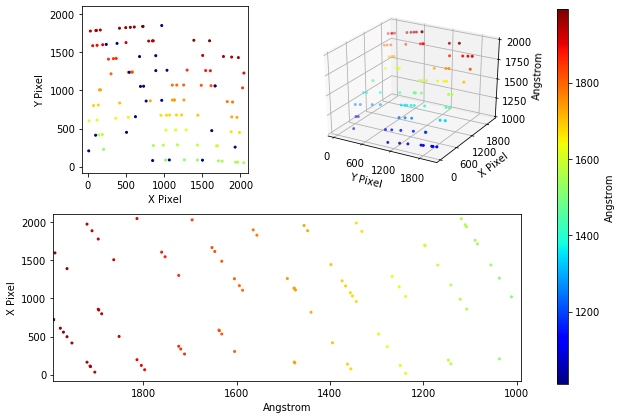

In [14]:
import pickle 

deg = 1
n_echelle = 10
n_each_echelle = 10
ccd_wl_low = 1000
ccd_wl_high = 2000
overlap = 0.1
ccd_noise = 1e-4
n_outliers_low = 1
n_outliers_high = 4
ref_wl_low = 800
ref_wl_high = 2200
ref_noise = 1e-4
ref_size = 200

min_bayes_factor = 10**9 

C = sn.number_of_combinations(200,3)

#ref = sn.build_ref(ref_wl_low, ref_wl_high, ref_noise, ref_size)
#with open('spectroscopy_net/data/ref.pkl', 'wb') as f:
    #pickle.dump(ref, f)

reference = open("spectroscopy_net/data/ref.pkl","rb")
reference = pickle.load(reference)

#obs, theta_true = sn.build_ccd(ref,ref_size,n_echelle,n_each_echelle,ccd_wl_low,ccd_wl_high,ccd_noise,overlap,n_outliers_low,n_outliers_high)
#with open('spectroscopy_net/data/obs.pkl', 'wb') as f:
    #pickle.dump(obs, f)
#with open('spectroscopy_net/data/theta_true.pkl', 'wb') as f:
    #pickle.dump(theta_true, f)

observations = open("spectroscopy_net/data/obs.pkl","rb")
observations = pickle.load(observations)

true_theta_values = open("spectroscopy_net/data/theta_true.pkl","rb")
true_theta_values = pickle.load(true_theta_values)

#multi_tree, echelle_ratios, echelle_wave_length = sn.build_tree(np.sort(ref[0]), 200, 3)

echelle_ratios = np.memmap("spectroscopy_net/data/ratios.memmap", dtype='float', mode='r', shape=(C, 1))
echelle_wave_length = np.memmap("spectroscopy_net/data/wave_length.memmap", dtype='float', mode='r', shape=(C, 3))
multi_tree = spatial.KDTree(echelle_ratios)

sn.graph_data(
    np.hstack(observations[0]), 
    np.hstack(observations[2]), 
    np.hstack(observations[5]), 
    np.hstack(observations[5]), 
    ccd_wl_low, 
    ccd_wl_high, 
    "jet", 
    "spectroscopy_net/data/spectral_data.pdf"
)

The graph above shows our simulated data:

TOP LEFT: Shows the measurements made on the ccd in x and y, It is clear here that there are distinct lines across the ccd, These are the echelle lines and the solutions along each are slightly different. The dark blue dots represent the outliers.

TOP RIGHT: Same as top left but in 3d where the Z axis is the value of the true wavelength solution.

BOTTOM: Shows how each echelle line maps from x pixel position to Angstrom.  

# Solving 

Below is a function whihc takes the list of echelle lines and the reference data + data trees and uses the hypothesis test and optimisation in Step 1 to solve each of the echelle orders independently 

In [15]:
sn.solve(
    "spectroscopy_net/data/model.pkl",
    np.sort(reference[0]), 
    observations[0], 
    observations[4], 
    true_theta_values, 
    multi_tree, 
    echelle_ratios, 
    echelle_wave_length, 
    ref_wl_high, 
    ref_wl_low,
    200,
    3
)

FROM HYPOTHESIS
Solution found
Bayes Factor: [2.22247348e+22]
True Theta: [1.050e-01 9.045e+02]
Best Theta: [1.04931767e-01 9.04500042e+02]
Theta Diff: 6.381275546259647e-09
FROM OPTIMIZING
Theta OP: 0.6666151440077951 0.18900030489610617
Theta diff after op: 817778.6995811282
***************
FROM HYPOTHESIS
Solution found
Bayes Factor: [8.40008768e+19]
True Theta: [1.070e-01 1.015e+03]
Best Theta: [1.07296146e-01 1.01500000e+03]
Theta Diff: 8.770424315126483e-08
FROM OPTIMIZING
Theta OP: 0.7986692737496981 0.19363082760304298
Theta diff after op: 1029832.4453192475
***************
FROM HYPOTHESIS
Solution found
Bayes Factor: [2.28507481e+19]
True Theta: [1.1000e-01 1.1255e+03]
Best Theta: [1.09769482e-01 1.12550001e+03]
Theta Diff: 5.318632885644794e-08
FROM OPTIMIZING
Theta OP: 0.10896107146204682 1125.758814486836
Theta diff after op: 0.06698601796866051
***************
FROM HYPOTHESIS
Solution found
Bayes Factor: [1.55834715e+36]
True Theta: [1.120e-01 1.236e+03]
Best Theta: [1.122

# STEP THREE:
## Non-Linear solutions

Now that we can solve n number of linear echelle lines we need to develope a way to solve non linear solutions.

Firstly lets create the data we will try do this with do this with.

1. 10 observations on a 2048 pixel ccd
2. Reference list contains 100 measurements
4. 0 outliers 

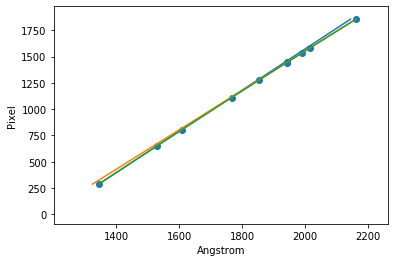

In [16]:
p = 1
k = 1
deg = 1
min_bayes_factor = 10**9

obs = np.sort(np.random.uniform(0, 2048, size=10))
theta_true = np.array([0.00001, 0.5, 1200])
y = np.polyval(theta_true, obs)

min_wl = np.polyval(theta_true, 1)
max_wl = np.polyval(theta_true, 2048)

wl_upper = max_wl+100
wl_lower = min_wl-100

ref = np.sort(np.hstack([y, np.random.uniform(wl_lower, wl_upper, 90)]))
obs += np.random.normal(0, 1e-4, size=10)
ref += np.random.normal(0, 1e-4, size=100)

C = sn.number_of_combinations(len(obs), p + 2)
indices, ratios, tree = grow_tree(np.sort(ref), p=1)

theta1 = np.polyfit(obs[:3], y[:3], deg=1)
theta2 = np.polyfit(obs[-3:], y[-3:], deg=1)
side1 = np.polyval(theta1, obs)
side2 = np.polyval(theta2, obs)
plt.plot(side1, obs)
plt.plot(side2, obs)
plt.plot(y, obs, 3)
plt.xlim(min_wl, max_wl)
plt.xlabel("Angstrom")
plt.ylabel("Pixel")
plt.scatter(y, obs)


# Graph Above
The blue dots represent the true solution, We can see there is some curvature. 

The Orange and Blue lines represent linear fits to the first and last three measurements in our observations (assumeing that we find the correct ratio in the KD Tree)

# Method

What we notice is that by splitting the data in half and using a linear fit on each section we construct a piecewise function that is almost as good as if we where to guess the correct polynomial (Green line).

So we can essentially use the linear hypothesis test we used early but twice on each echelle line to guess the solutions to each half.
Then calculate the probability of how well that piece wise function fits the data. 

If we pass these first two steps then we should know which observation lines match to what reference line. Once we know this when we optimse we can give it the observations, best matches and tell it to optimize for a 2nd order polynomial whihc should give us the correct solution. 


# Intersection Function 

Below is a function used to find the x, y point of intersection of two linear lines. This is needed to create our piece wise function.



In [17]:
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

In [18]:
a1 = np.array([side1[0], obs[0]])
a2 = np.array([side1[2], obs[2]])

b1 = np.array([side2[-1], obs[-1]])
b2 = np.array([side2[-3], obs[-3]])

intersect = seg_intersect(a1, a2, b1, b2)

idx = np.where(obs < intersect[1])
low = obs[idx]

idx = np.where(obs > intersect[1])
high = obs[idx]

solution = np.piecewise(
    obs, 
    [obs < intersect[1], obs >= intersect[1]], 
    [(low*theta1[0])+theta1[1], (high*theta2[0])+theta2[1]]
)

# Above
I construct vectors out of the three points used to create of linear fit and feed this into the ```seg_intersection``` function which returns the point of intersection.

With this point I then use ```np.piecewise``` to construct the piece wise function made out of the two lines.

# Below

I have to change the hypothesis test functions slightly to allow them to take the hypothesised piecewise function solutions into the foreground model likelihood calculation. In Step one and Step 2 the hypothesised Angstrom solutions where being calculated inside the function but here we do it outside. 

We also had to remove the invarience out of the foreground model as it was restricting the gausians around the correct match to much and was lowering the probability enormously

In [19]:
def ln_likelihood1(w, wl_guess_free, px_obs_free, ref):
    w = np.atleast_2d(w).T
    bg = np.log(1-w) + np.atleast_2d(ll_background(px_obs_free))
    ll_fore, best_solution = ll_foreground1(wl_guess_free, px_obs_free, ref)
    
    fg = np.log(w) + np.atleast_2d(ll_fore)
    ln_like = np.sum(special.logsumexp([bg, fg], axis=0), axis=1)
    
    return ln_like, best_solution

def ll_background(px_obs_free):
    return -np.ones(len(px_obs_free)) * np.log(wl_upper - wl_lower)

def ll_foreground1(wl_guess_free, px_obs_free, ref, px_obs_err=1e-4, wl_ref_err=1e-4):
    
    wl_obs = wl_guess_free.reshape(-1, 1)

    D = spatial.distance_matrix(wl_obs, ref.reshape(-1, 1))
    
    idx = np.argmin(D, axis=1)
    best_solution = ref[idx]
    
    chisq = np.min(D, axis=1)**2
    ivar = 1e-2**-2
    
    ll_fore = -0.5 * chisq # * ivar
    return ll_fore, best_solution

def ln_prior(w):
    lp = np.zeros(np.atleast_1d(w).size)
    lp[(w > 1) | (w < 0)] = -np.inf
    return lp

def ln_probability1(w, wl_guess_free, px_obs_free, ref):
    ln_like, best_solution = ln_likelihood1(w, wl_guess_free, px_obs_free, ref)
    ln_prob = ln_prior(w) + ln_like
    return ln_prob, best_solution

[28.60413775]


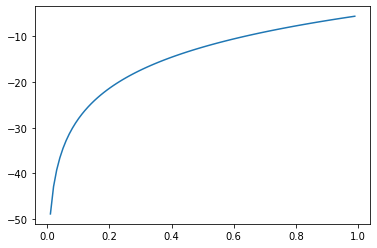

In [20]:
ln_bg_prob = np.sum(ll_background(obs))

ws = np.linspace(0, 1, 100)[1:-1]
ln_prob, best_solution = ln_probability1(ws, solution, obs, ref)

w = ws[np.argmax(ln_prob)]

fig, ax = plt.subplots()
ax.plot(ws, ln_prob)

ln_prob, best_solution = ln_probability1(w, solution, obs, ref)

bayes_factor = np.exp(ln_prob - ln_bg_prob)


print(np.log10(bayes_factor))

# Solution Found

Now the we believe we have the correct matches to all of our observed emission lines we can optimize for a 3rd order polynomial and obtain the best possible solution.

## NEEDS FIXING
something not quite right with this, compiles but when trying to optimze we obtain time out error

In [21]:
import pystan
import numpy as np
M = 10
x = obs
data = best_solution

poly_data = {'N': M, 
               'y': data,
               'y_err' : 1e-4*np.ones_like(data),
               'x': x,
               'bg_lower': wl_lower,
               'bg_upper': wl_upper
               
               }

poly_model = """
data {
    int<lower=1> N;
    real y[N];
    real y_err[N]; 
    real x[N]; 
    real bg_lower;
    real bg_upper;   
}
parameters {
    real<lower=0, upper=1> theta;
    real m;
    real p;
    real<lower=0> c;
    real<lower=0> bg_variance; 
}
model {
    for (n in 1:N) {
    target += log_mix(theta,
                      normal_lpdf(y[n] | p * x[n]^2 + m * x[n] + c, y_err[n]),
                      normal_lpdf(y[n] | p * x[n]^2 + m * x[n] + c, pow(pow(y_err[n], 2) + bg_variance, 0.5)));
    }   
}
""" 
#sm3 = pystan.StanModel(model_code=poly_model)

In [22]:
#op3 = sm3.optimizing(data=poly_data);
#print("Outlier Fraction", op3[("theta")])
#print("2nd order:", op3[("p")])
#print("1st order:", op3[("m")])
#print("Intercept", op3[("c")])

print("Solution Diff:", data - y)
print("Theta Diff:", theta_true - np.polyfit(x, data, 2))

Solution Diff: [-1.03178257e-04 -1.14654056e-05 -2.02566151e-04 -9.80198067e-05
 -3.08587398e+00 -1.25633958e-04  1.51430011e-05 -5.11929702e-05
  1.38405460e-05  3.42450494e-06]
Theta Diff: [-1.31662052e-06  2.91014696e-03 -1.00998300e+00]


# Lets do this blind now:

Now we atempt to do what has been done above but blindly, this time we have to find the matches first then try to create the piece wise solution and evaltue how well it fits the data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial, special, optimize as op
from itertools import combinations
from tqdm import tqdm
from time import time
from IPython.display import Latex
import pystan
import spectroscopy_net as sn
import math
import random 
random.seed(1) 

theta_true = np.array([-4.4e-06,  7.8e-02,  4.8e+03])
N_ref = 20
N_obs = 15
N_pix = 2048
wl_lower, wl_upper = (4790, 4950)
deg = 1
f = 0
p = 1 

data_kwds = dict(N_ref=N_ref, N_obs=N_obs, N_pix=N_pix,
                 wl_lower=wl_lower, wl_upper=wl_upper,
                 f=f, intrinsic_px_obs_err=1e-3, intrinsic_wl_ref_err=1e-4)

obs, ref = sn.generate_data(theta_true, **data_kwds)

px_obs, amp_obs, px_obs_err, px_sol = obs
wl_ref, amp_ref, wl_ref_err = ref

trees = sn.grow_tree(wl_ref, p=p)
indices, ratios, tree = trees

fig, ax = plt.subplots()
ax.scatter(px_obs, px_sol)
for each in wl_ref:
    ax.axhline(each, c='#666666', lw=0.5, zorder=-1)

 40%|███▉      | 455/1140 [00:04<00:06, 105.93it/s]

Unsolved problem
Bayes Factor: [942.22630716]
Best Theta: [1.81542918e-03 4.83329510e+03]


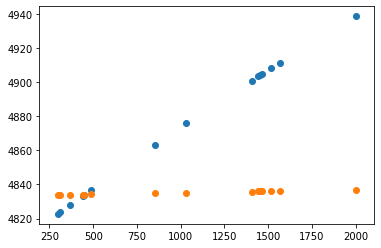

In [2]:
results = sn.solve_linear(obs, ref, trees)

plt.scatter(px_obs, px_sol)
plt.scatter(px_obs, np.polyval(results[1], px_obs))

The function below and everything used to test the "correctness" of the solutions from different sections of the piece wise function can be found in the piece_wise.py script. This method of solving will fail if the first guess from the first segement is incorrect, we dont have a good way yet to re test failed solutions that become informed from later piee wise segments

Unsolved problem
Bayes Factor: [1.94231341e+10]
Unsolved problem
Bayes Factor: [39692.77457787]
Unsolved problem
Bayes Factor: [4.47799833e+08]
likely solution


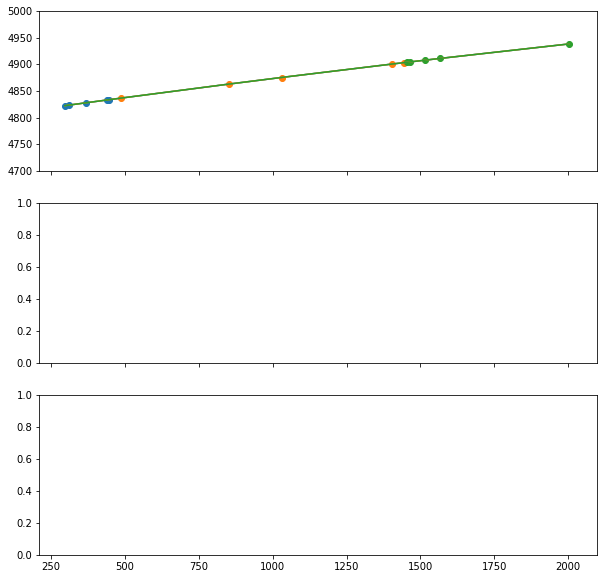

In [3]:
conditions = sn.solve_piecewise_test(obs, ref, trees, k=200, min_bayes_factor=10**11, max_split_depth=3)

# Real data

Now we try this on some real data, This data fails because there is an enourmouse fraction of outliers, still not sure how to deal with this. 

In [4]:
obs = np.loadtxt("spectroscopy_net/data/hd122563red_lamp1034ffbspecs.wsol")
x = obs[obs[:, 0] == 70][:, 1]
x_sol = obs[obs[:, 0] == 70][:, -1]
obs = (x, x_sol)

ref = np.loadtxt("spectroscopy_net/data/mike_ThAr.dat")
ref = np.sort(ref)
idx = np.where(ref < x_sol.min())
ref = np.delete(ref, idx)
idx = np.where(ref > x_sol.max())
ref = np.delete(ref, idx)

trees = sn.grow_tree(ref, p=p)
indices, ratios, tree = trees

In [5]:
x, ref

(array([ 112.803,  203.196,  210.4  ,  237.446,  269.373,  341.731,
         380.035,  386.663,  437.041,  443.012,  464.871,  483.035,
         515.521,  537.691,  557.466,  617.275,  632.827,  665.702,
         760.285,  796.867,  812.457,  822.001,  843.43 ,  944.305,
         954.971,  983.253, 1018.714, 1061.38 , 1070.724, 1079.318,
        1095.98 , 1203.034, 1229.593, 1249.428, 1294.411, 1314.583,
        1321.85 , 1341.576, 1354.934, 1404.032, 1413.679, 1458.389,
        1474.479, 1484.901, 1496.654, 1502.378, 1555.133, 1592.403,
        1611.064, 1667.279, 1673.379, 1849.909, 1904.385, 1914.806,
        2020.235]),
 array([4847.809, 4863.172, 4865.477, 4872.916, 4878.733, 4879.863,
        4889.042, 4894.955, 4904.751, 4919.815, 4933.209, 4939.642,
        4945.458, 4965.079, 4972.159]))

function is slightly different but does the extact same thing

969it [00:10, 89.99it/s]                         
  3%|▎         | 13/455 [00:00<00:03, 123.34it/s]

Unsolved problem
Bayes Factor: [19108744.77556387]


816it [00:05, 145.76it/s]                         
  3%|▎         | 12/455 [00:00<00:03, 118.85it/s]

Unsolved problem
Bayes Factor: 10


816it [00:06, 128.53it/s]                         
  2%|▏         | 9/455 [00:00<00:05, 82.60it/s]

Unsolved problem
Bayes Factor: 10
No match


816it [00:08, 93.18it/s]                          
  3%|▎         | 14/455 [00:00<00:03, 135.57it/s]

Unsolved problem
Bayes Factor: [14831648.33894605]


816it [00:05, 145.35it/s]                         
  2%|▏         | 11/455 [00:00<00:04, 103.72it/s]

Unsolved problem
Bayes Factor: 10


969it [00:07, 126.84it/s]                         
  2%|▏         | 8/455 [00:00<00:05, 77.27it/s]

Unsolved problem
Bayes Factor: 10
No match


816it [00:08, 94.11it/s]                          
  3%|▎         | 13/455 [00:00<00:03, 127.41it/s]

Unsolved problem
Bayes Factor: [5557896.34546796]


969it [00:06, 147.44it/s]                         
  3%|▎         | 13/455 [00:00<00:03, 128.91it/s]

Unsolved problem
Bayes Factor: 10


816it [00:06, 134.99it/s]                         


Unsolved problem
Bayes Factor: 10
No match


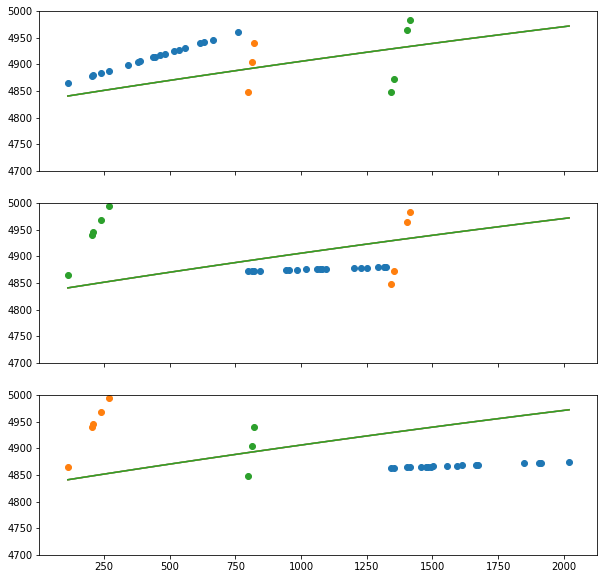

In [6]:
conditions = sn.solve_piecewise_mike(obs, ref, trees, k=10, min_bayes_factor=10**9, max_split_depth=3)